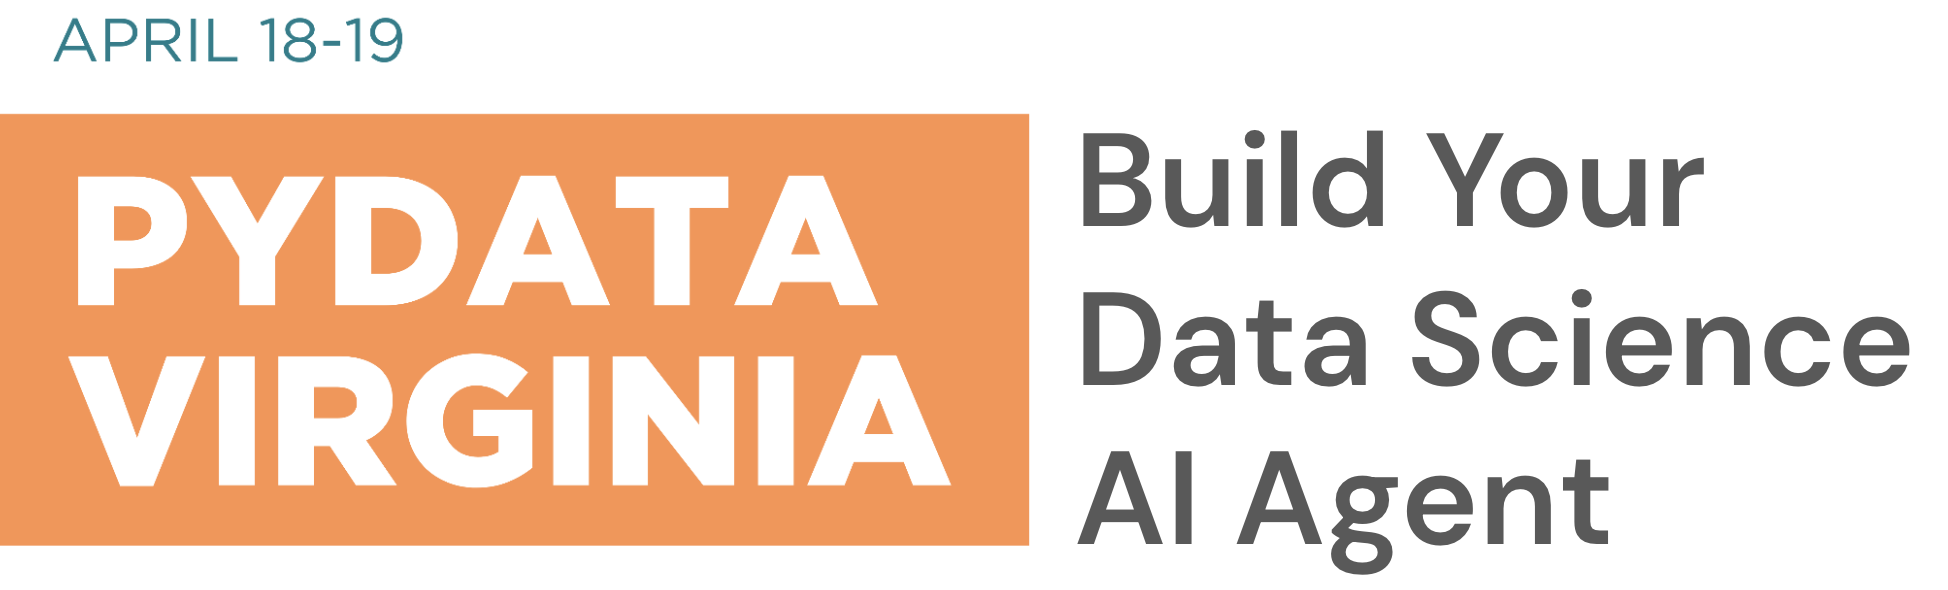

# Pydata Virginia 2025 - Tutorial - Build Your Own Data Science AI Agents

## Speakers: [Astha Puri](https://www.linkedin.com/in/astha-puri/), [Chuxin Liu](https://www.linkedin.com/in/chuxin-liu/), [Niharika Krishnan](https://www.linkedin.com/in/niharikakrishnan/), [Michelle Rojas](https://www.linkedin.com/in/michelle-rojas-526422302/)

In this notebook, we will walk you through how to build a multi-agent system for a data science task using LangGraph. Let's dive in! 🚀

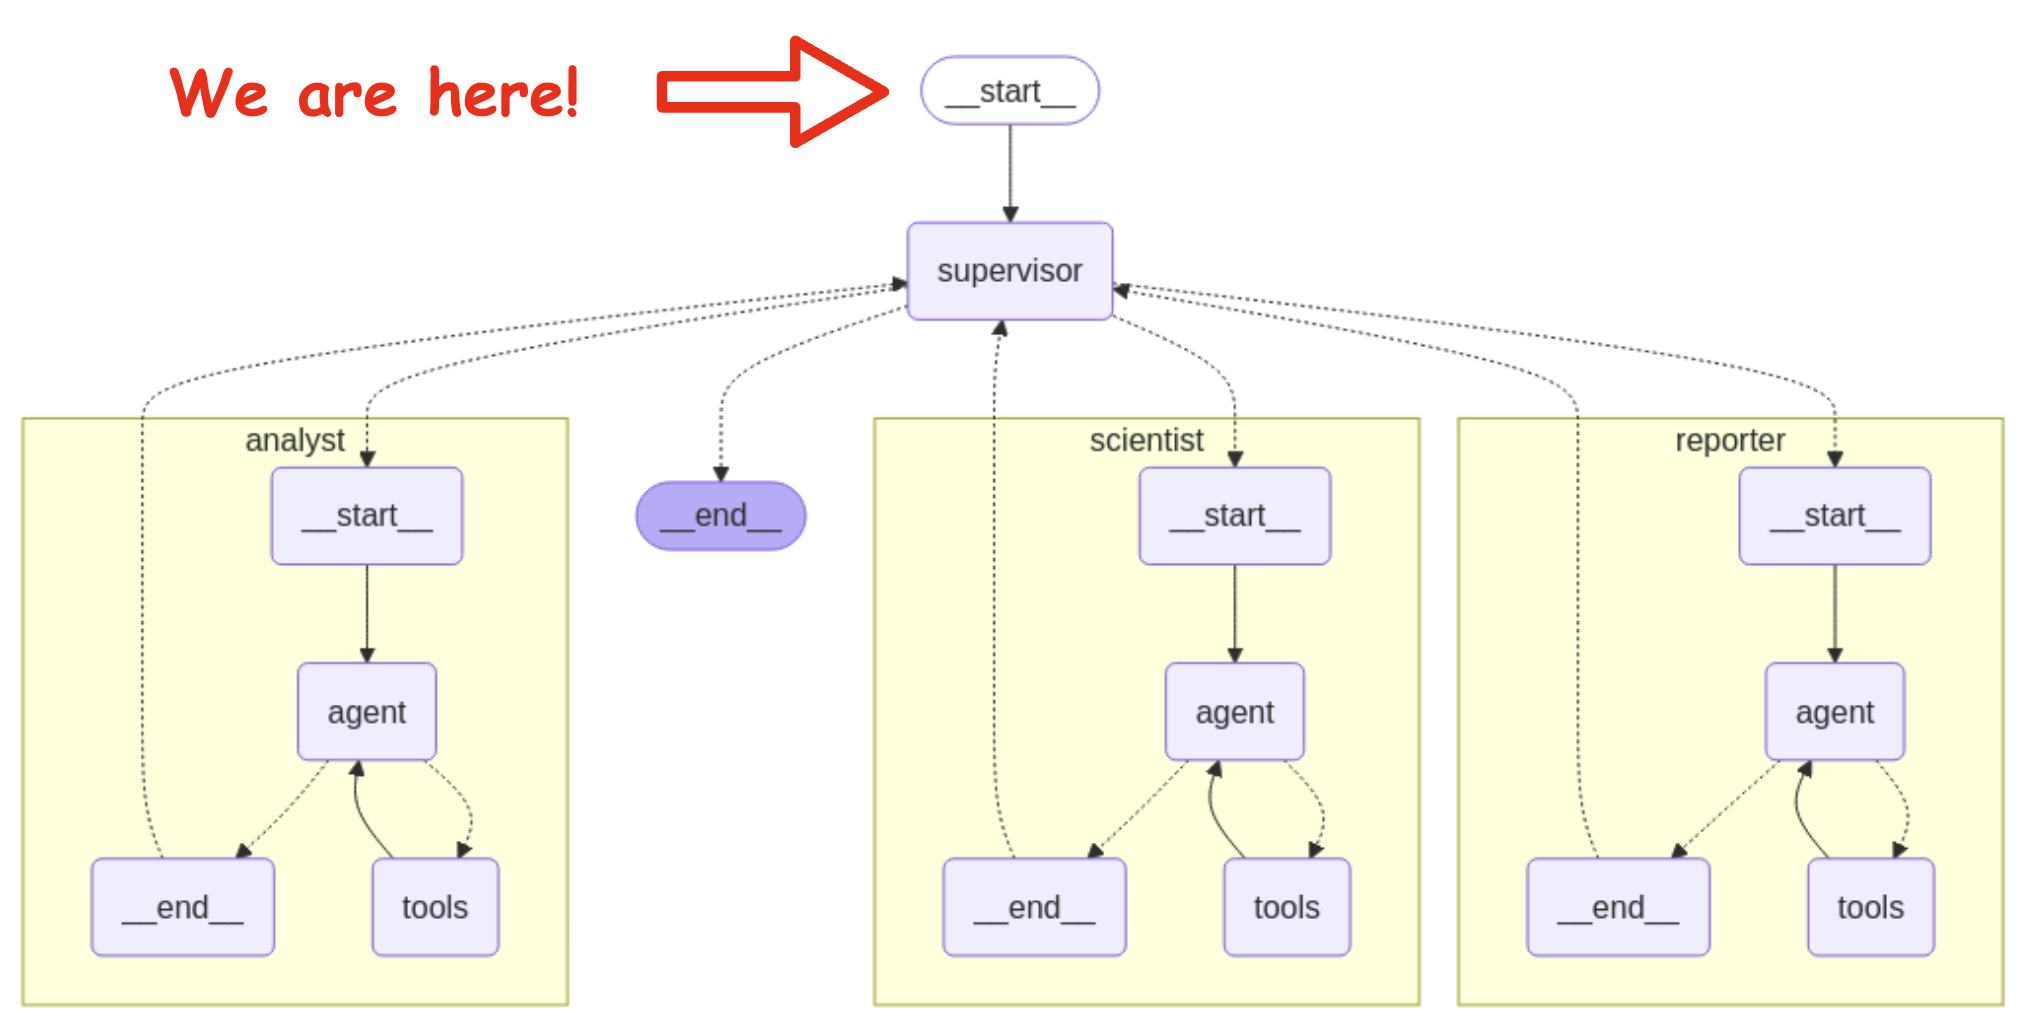



## Step 1: Libraries and OpenAI API Key

In [1]:
!pip install langchain-community langchain-core langgraph python-pptx langchain-openai langsmith

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 493.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 26.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.9/148.9 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.8/472.8 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 30.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.4/169.4 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223

In [ ]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from markdown import Markdown
from typing import Dict, List, Any, Tuple, Literal
from IPython.display import display, Image

# LangGraph and LangChain imports
from langchain_core.messages import AIMessage, HumanMessage
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode
from langchain.tools import tool
from langsmith.wrappers import wrap_openai

In [ ]:
import os
from google.colab import userdata
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')
os.environ["LANGSMITH_API_KEY"] = userdata.get('LANGSMITH_API_KEY')

TimeoutException: Requesting secret OPENAI_API_KEY timed out. Secrets can only be fetched when running from the Colab UI.

In [ ]:
from typing import Literal,Annotated
from typing_extensions import TypedDict
from langgraph.graph import MessagesState, END
from langgraph.types import Command
from langgraph.graph.message import add_messages

llm = ChatOpenAI(model="gpt-4o", temperature=0)

# node that doesn’t do work itself, but instead decides which node should run next
class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""
    next: Literal["analyst", "scientist", "reporter", "FINISH"]

#global memory/shared state that moved between nodes
class State(TypedDict):
    messages: Annotated[list, add_messages] # chat history
    next: str # next agent to call
    eda_images: list[str]

## Step 2: Agents - Supervisor

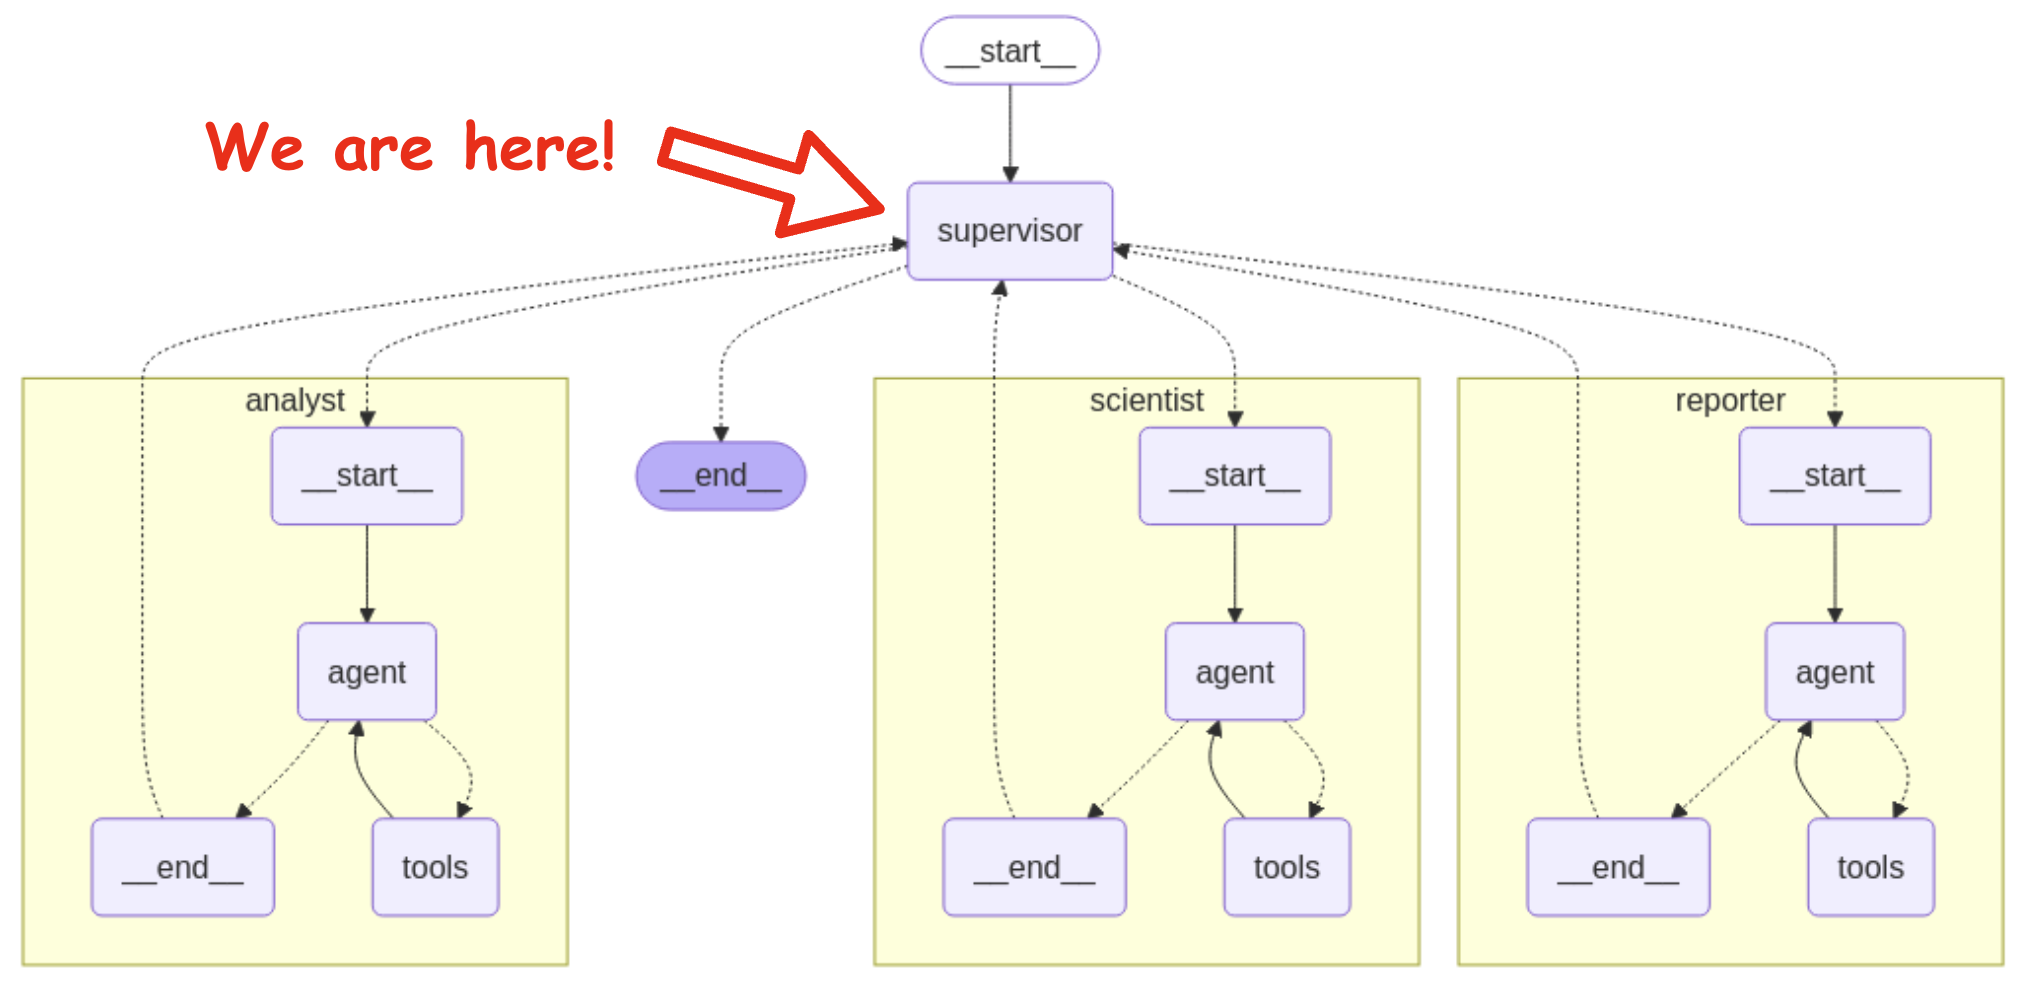

In [ ]:
# Our team supervisor is an LLM node. It just picks the next agent to process
# and decides when the work is completed
members = ["analyst", "scientist", "reporter"]

SUPERVISOR_AGENT_PROMPT = f"""You are a supervisor tasked with managing a conversation between the following workers:
                              {members}.

                              Given the following user request, respond with the worker to act next.
                              Each worker will perform a task and respond with their results and status.
                              Analyze the results carefully and decide which worker to call next accordingly.
                              Remember analyst agent can do exploratory analysis, scientist can build predictive models
                              and reporter can build presentations for executives.
                              When finished, respond with FINISH."""

# supervisor node takes current state with "messages" and "next" and returns a command object with "goto" and "next"
def supervisor_node(state: State) -> Command[Literal["analyst", "scientist", "reporter","__end__"]]:
    # prompt prep
    messages = [{"role": "system", "content": SUPERVISOR_AGENT_PROMPT},] + state["messages"]
    # Respond which agent to call next or finish - typesafe routing decision eg: {"next": "analyst"}
    response = llm.with_structured_output(Router).invoke(messages)
    goto = response["next"]
    if goto == "FINISH":
        goto = END

    return Command(goto=goto, update={"next": goto})

## Step 3: Agents - Analyst

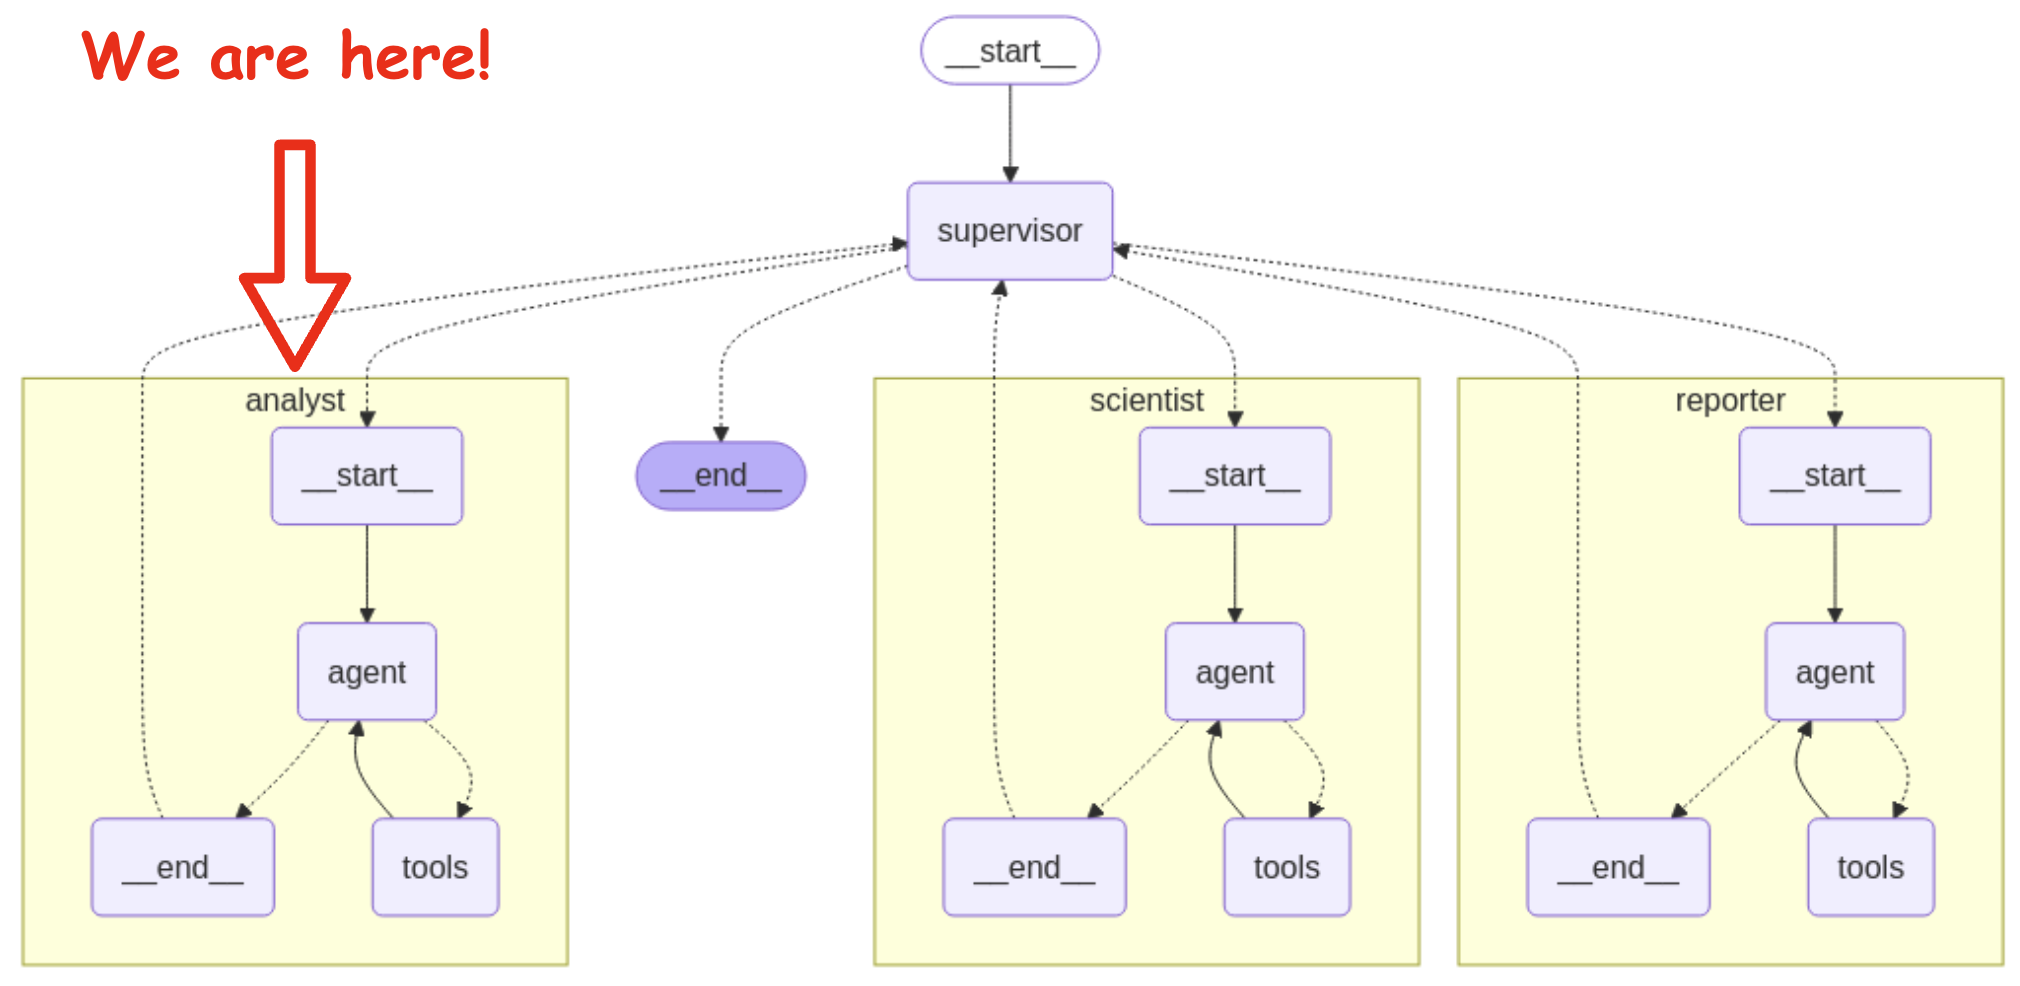

In [ ]:
# Defining functions for Exploratory Data Analysis

# Function to generate histogram for a given column
def generate_histogram(data, column, image_dir, filename):
    """Generates and saves a histogram for a given column."""
    plt.figure(figsize=(6, 4))
    data[column].hist(bins=20, color="skyblue", edgecolor="black")
    plt.title(f"Distribution of {column}")
    plt.xlabel(column)
    plt.ylabel("Frequency")
    plt.grid(False)

    # Save image in filepath: eda_images/filename.png
    filepath = os.path.join(image_dir, filename)
    plt.savefig(filepath, bbox_inches="tight")
    plt.close()
    return filepath

# Function to Generate Correlation Heatmap
def generate_correlation_heatmap(data, image_dir, filename):
    """Generates and saves a correlation heatmap."""
    plt.figure(figsize=(6, 4))
    sns.heatmap(data.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
    plt.title("Feature Correlation Heatmap")

    # Save image in filepath: eda_images/filename.png
    filepath = os.path.join(image_dir, filename)
    plt.savefig(filepath, bbox_inches="tight")
    plt.close()
    return filepath

# Function to Generate Box Plots
def generate_boxplot(data, column, image_dir, filename):
    """Generates and saves a box plot for a given column."""
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=data[column], color="lightblue")
    plt.title(f"{column} Box Plot")

    # Save image in filepath: eda_images/filename.png
    filepath = os.path.join(image_dir, filename)
    plt.savefig(filepath, bbox_inches="tight")
    plt.close()
    return filepath

In [ ]:
@tool
def perform_eda() -> str:
    """Perform exploratory data analysis on the diabetes dataset."""

    # Setup directory for
    image_dir = "eda_images"
    image_paths = []
    os.makedirs(image_dir, exist_ok=True)

    # Load diabates dataset - Ensure the dataset is uploaded to colab
    df = pd.read_csv("diabetes.csv")

    # Basic Stats
    stats = df.describe().to_dict()

    # Check for missing values
    missing_values = df.isnull().sum().to_dict()

    # Check for zero values (which might be missing values in this dataset)
    zero_values = {col: (df[col] == 0).sum() for col in df.columns}

    # Correlation with target
    correlations = df.corr()["Outcome"].drop("Outcome").to_dict()

    # Column distribution
    eda_columns = ["Age", "BMI", "Glucose"]  # Select columns for EDA
    for col in eda_columns:
        hist_img = f"{col}_hist.png"
        distribution_filepath = generate_histogram(df, col, image_dir, hist_img)
        image_paths.append(distribution_filepath)

    # Add Correlation Heatmap
    corr_img = "correlation_heatmap.png"
    corr_filepath = generate_correlation_heatmap(df, image_dir, corr_img)
    image_paths.append(corr_filepath)

    # Add Box plot for outliers setection ---
    for col in eda_columns:
        box_img = f"{col}_boxplot.png"
        boxplot_filepath = generate_boxplot(df, col, image_dir, box_img)
        image_paths.append(boxplot_filepath)

    # Result dictionary
    eda_results = {
          "basic_stats": stats,
          "missing_values": missing_values,
          "zero_values": zero_values,
          "correlations_with_target": correlations,
          "image_paths": image_paths
    }

    return eda_results

In [ ]:
from langchain_core.messages import HumanMessage
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import create_react_agent
from langchain_core.messages import trim_messages
import ast
import re

# Create analyst sub-agent
analyst_agent = create_react_agent(
    llm, tools=[perform_eda], state_modifier="""You are a data analyst. You take input csv file, do exploratory data analysis.
                                                Do not build any predictive models. Only do descriptive analysis.
                                                        Once your task is done report your results back to the supervisor."""
)

# Extra Tidbit:
# Based on paper “ReAct: Synergizing Reasoning and Acting in Language Models” (https://arxiv.org/abs/2210.03629)

# Define the Node Function for the Analyst Agent
def analyst_node(state: State) -> Command[Literal["supervisor"]]:

    # Invoke analyst agent and pass the state
    result = analyst_agent.invoke(state)

    # print(result)

    # To Do: Parsing the Tool Message from AI Message & Human Message to get image paths
    tool_output = None
    for msg in result["messages"]:
      if msg.type == "tool":
        cleaned = re.sub(r"np\.int64\((\d+)\)", r"\1", msg.content)
        tool_output = ast.literal_eval(cleaned)
        break

    # Extracting the image_paths from Tools Message
    image_paths = tool_output.get("image_paths", []) if tool_output else []

    # Return AI message as Human Message to Supervisor (goto)
    # Note: If you returned an AIMessage, the analyst might interpret that as its own past response — and just stay silent.
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="analyst")
            ],
            "eda_images": image_paths
        },
        goto="supervisor",
    )

## Step 4: Agents - Scientist

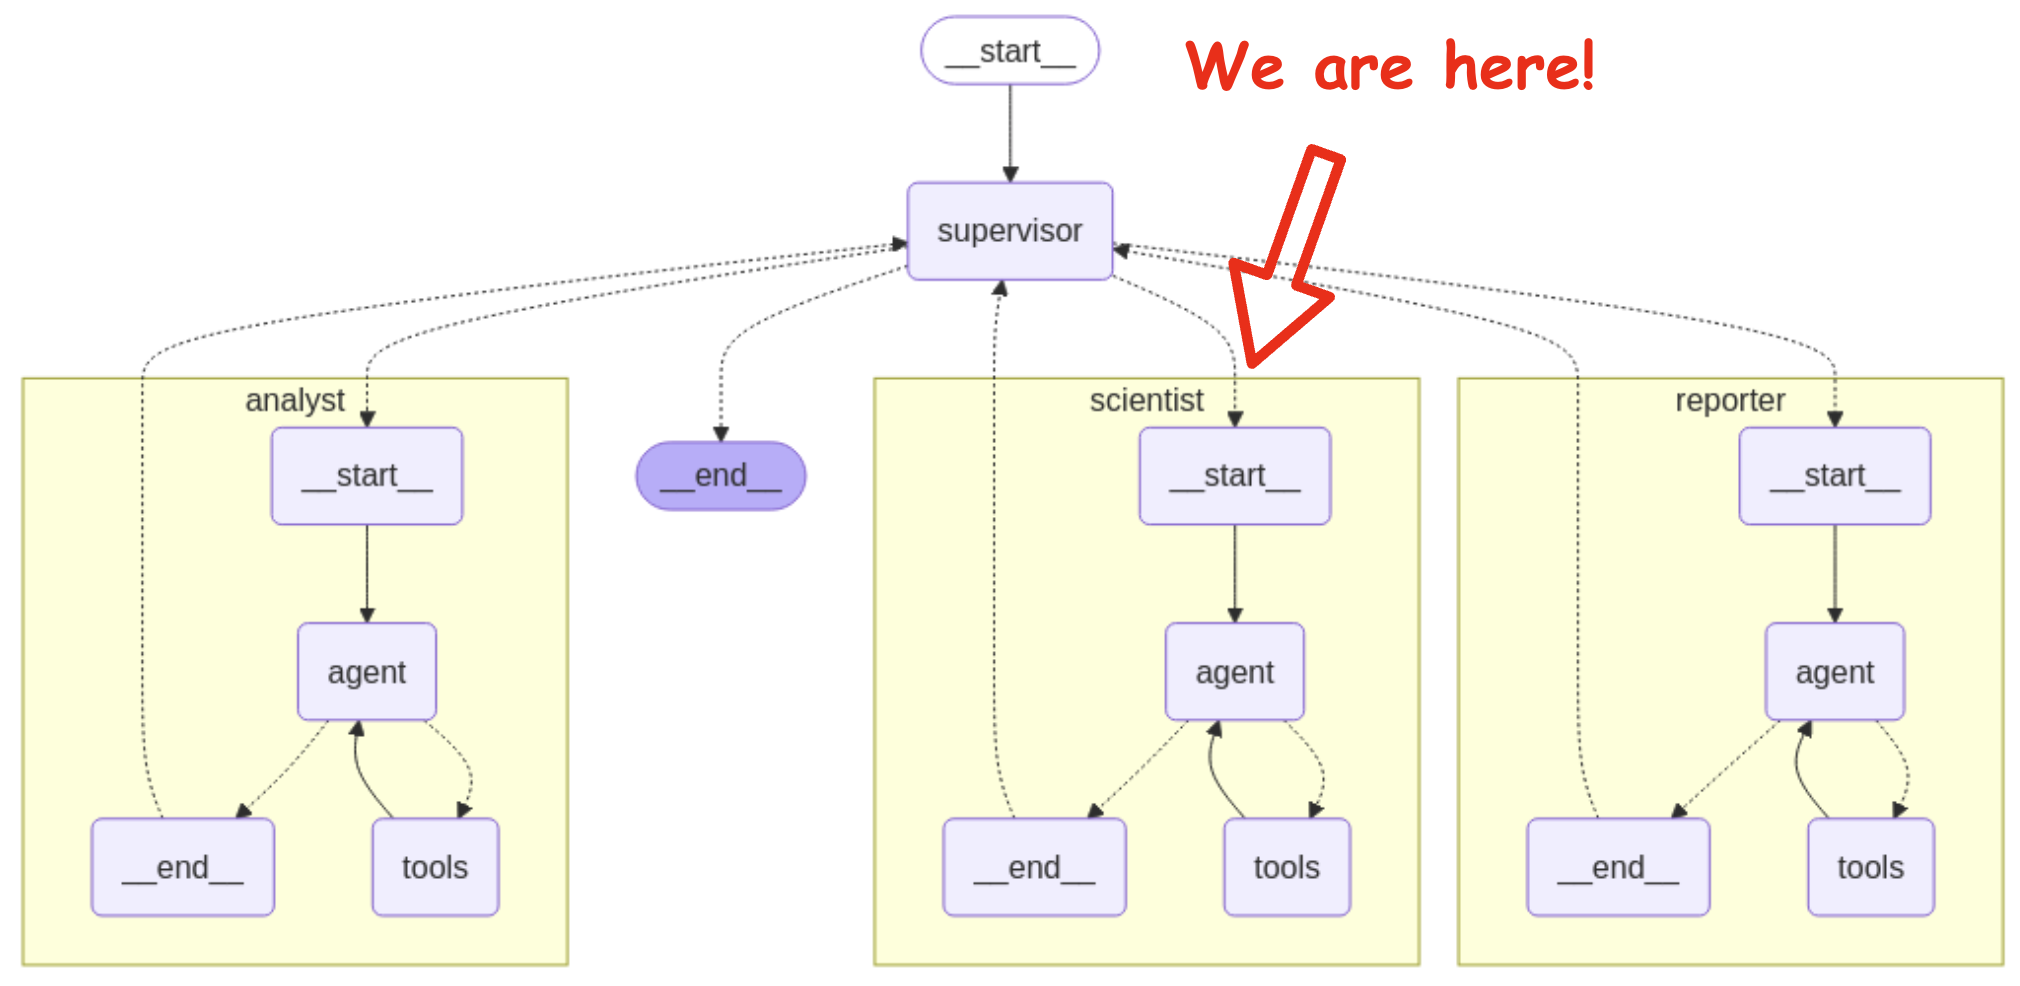

In [ ]:
@tool
def train_model():
    """Train a Random Forest model on the diabetes dataset."""

    df = pd.read_csv("diabetes.csv")

    X = df.drop(columns=["Outcome"])
    y = df["Outcome"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Build a simple classification model
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    # Calculate performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    class_report = classification_report(y_test, y_pred, output_dict=True)
    conf_matrix = confusion_matrix(y_test, y_pred).tolist()
    feature_importances = dict(zip(X.columns, model.feature_importances_))

    # Return model results from tool to agent
    model_results = {
            "accuracy": accuracy,
            "classification_report": class_report,
            "confusion_matrix": conf_matrix,
            "feature_importances": feature_importances
    }

    return model_results

In [ ]:
# Create a scientist sub-agent
scientist_agent = create_react_agent(
    llm, tools=[?], state_modifier="""You are a data scientist. You take input csv file, build predictive model.
                                                Only build the most relevant predictive model related to the question.
                                                        Once your task is done report your results back to the supervisor."""
)
# answer: train_model

# Define the Node Function for the Analyst Agent
def scientist_node(state: State) -> Command[Literal["supervisor"]]:

    # Invoke scientist agent and pass the state
    result = scientist_agent.invoke(?)

    # Return AI message as Human Message to Supervisor (goto)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="scientist")
            ]
        },
        goto="supervisor",
    )
# answer: state

## Step 5: Agents - Reporter

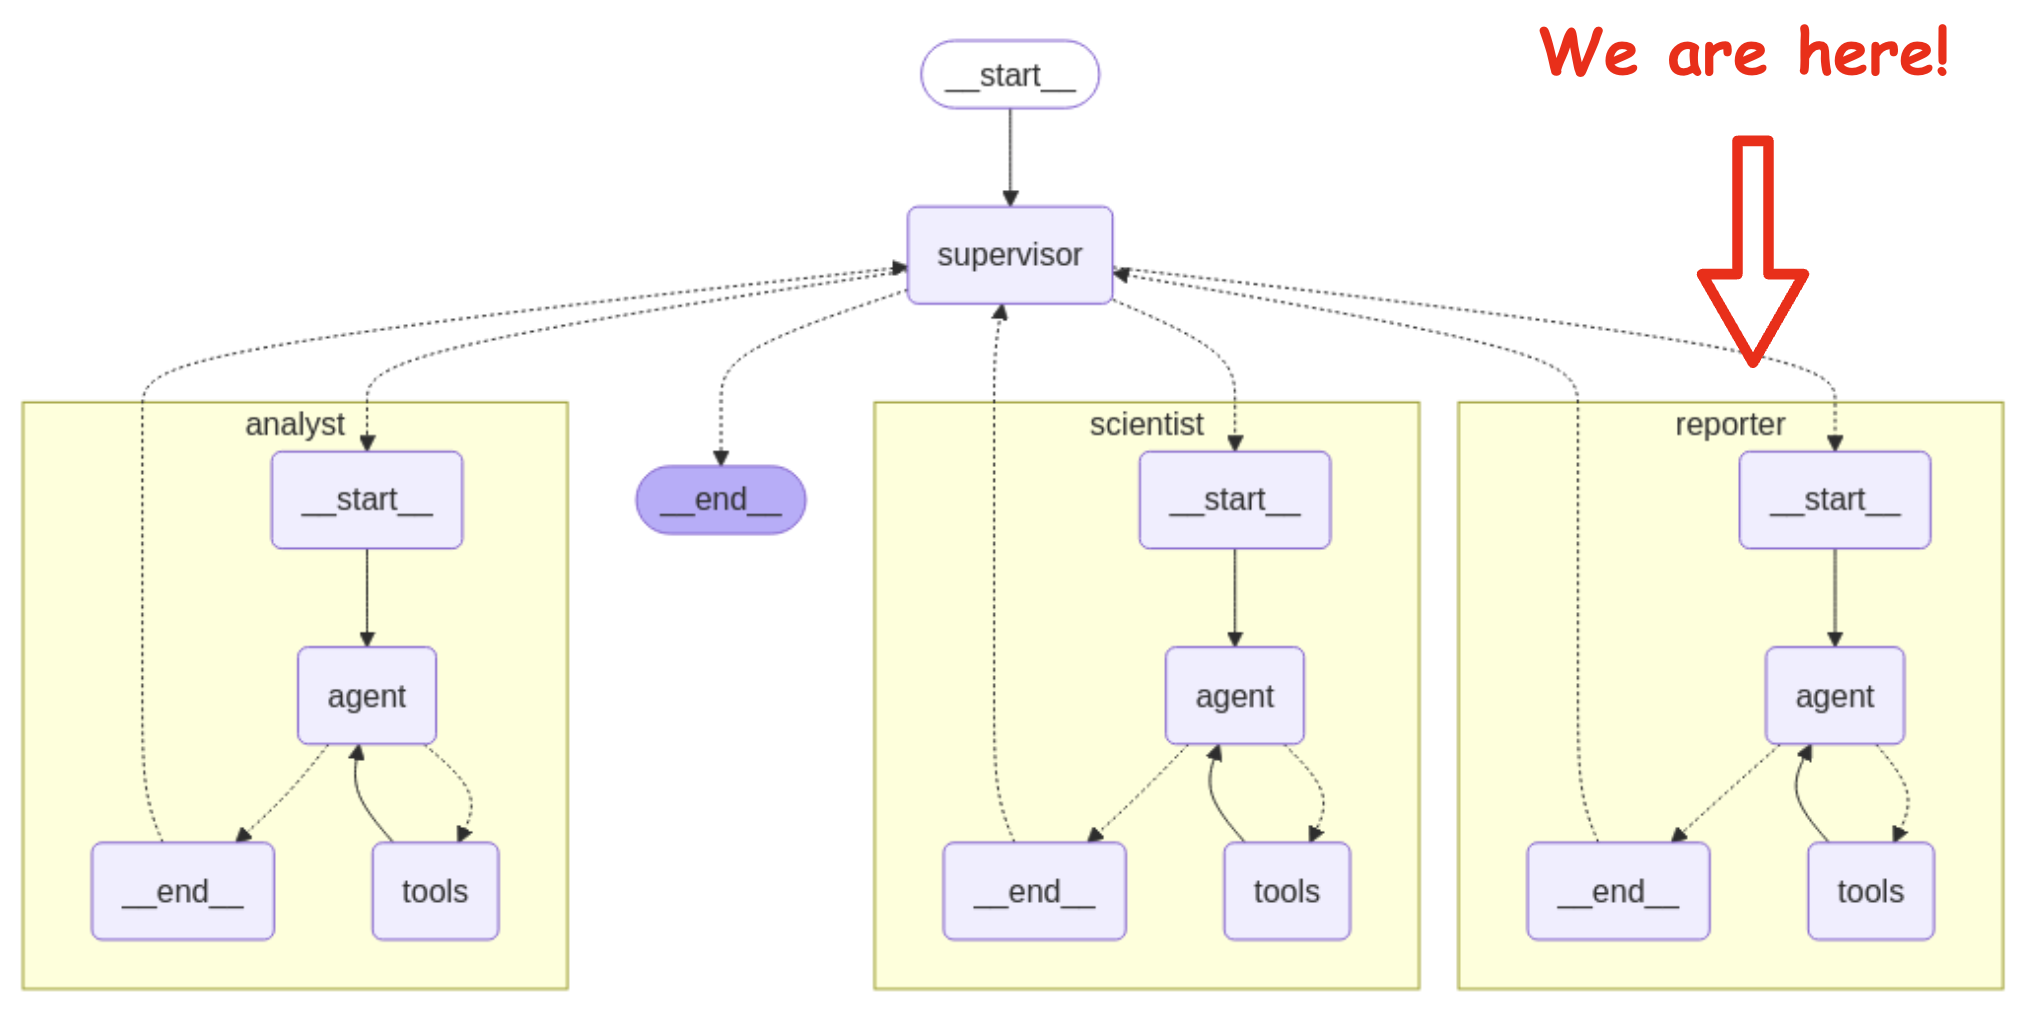

In [ ]:
@tool
def presentation(content: str, image_paths: list[str], theme_path: str = None):
    """
    Build a PowerPoint presentation with a background theme.

    Args:
        content: Text content to include in the presentation.
        image_paths: List of image paths to include in the presentation.
        theme_path: (Optional) Path to a PowerPoint theme/template (.pptx) file.
    """

    import os
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    from pptx import Presentation
    from pptx.util import Inches, Pt
    from pptx.dml.color import RGBColor

    try:
        # Load Presentation Theme (Optional)
        theme_path = None  # Provide a theme path if available
        prs = Presentation(theme_path) if theme_path and os.path.exists(theme_path) else Presentation()

        # Set Background Color Function
        def set_slide_background(slide, color=RGBColor(240, 240, 240)):
            """Sets a solid background color for a slide."""
            background = slide.background
            fill = background.fill
            fill.solid()
            fill.fore_color.rgb = color

        # Function to Add Content Slide
        def add_content_slide(prs, title_text, content_text, bg_color=RGBColor(220, 235, 255)):
            """Adds a slide with title, content, and background color."""
            slide_layout = prs.slide_layouts[1]  # Title and Content Layout
            slide = prs.slides.add_slide(slide_layout)
            set_slide_background(slide, bg_color)

            # Title Formatting
            title = slide.shapes.title
            title.text = title_text
            title.text_frame.paragraphs[0].font.bold = True
            title.text_frame.paragraphs[0].font.size = Pt(32)

            # Content Text Box
            text_box = slide.shapes.add_textbox(Inches(1), Inches(1.5), Inches(8), Inches(5))
            text_frame = text_box.text_frame
            text_frame.word_wrap = True

            for paragraph in content_text.split("\n"):
                p = text_frame.add_paragraph()
                p.text = paragraph
                p.font.size = Pt(20)

        # Function to Add Image Slide
        def add_image_slide(prs, title_text, img_path):
            """Adds a slide with an image."""
            slide_layout = prs.slide_layouts[5]  # Title Only Layout
            slide = prs.slides.add_slide(slide_layout)

            title = slide.shapes.title
            title.text = title_text

            left = Inches(1)
            top = Inches(1.5)
            width = Inches(8)
            slide.shapes.add_picture(img_path, left, top, width=width)

        # --- STEP 1: ADD TITLE SLIDE ---
        title_slide_layout = prs.slide_layouts[0]
        slide = prs.slides.add_slide(title_slide_layout)
        slide.shapes.title.text = "AI Agent for Diabetes Prediction"
        slide.placeholders[1].text = "Machine Learning Workflow & Insights"

        # --- STEP 2: ADD CONTENT SLIDES ---
        content_slides = """
        This AI Agent predicts diabetes based on patient health records.
        It uses machine learning to classify high-risk patients.
        Steps in the workflow:
        1. Data Collection
        2. Data Preprocessing
        3. Feature Engineering
        4. Model Training
        """
        add_content_slide(prs, "AI Agent Workflow", content_slides)

        for path in image_paths:
          if os.path.exists(path):
              slide = prs.slides.add_slide(prs.slide_layouts[6])  # blank layout
              set_slide_background(slide, RGBColor(255, 255, 255))
              slide.shapes.add_picture(path, Inches(1), Inches(1.5), width=Inches(8))

        # --- SAVE PRESENTATION ---
        file_path = os.path.abspath("ai_agent_presentation.pptx")
        prs.save(file_path)

        return {
            "status": "success",
            "message": f"Presentation created successfully at {file_path}",
            "file_path": file_path
        }

    except Exception as e:
        return {
            "status": "error",
            "message": f"Failed to create presentation: {str(e)}"
        }

In [ ]:
# Create reporter Sub-Agent
reporter_agent = create_react_agent(
    llm,
    tools=[?],
    state_modifier="""You are a reporter who makes presentations. You create presentations for executives.
                     Take the scientist's analysis and build a powerpoint presentation summarizing the key findings.
                     You MUST use the content from the data scientist.
                     Once your task is done, report results back to the supervisor."""
)
# Answer: presentation

# create node function for reporter sub-agent
def reporter_node(state: State) -> Command[Literal["supervisor"]]:

    last_message = state["messages"][-1].content if state["messages"] else ""

    image_paths = state.get("eda_images", [])

    # Create message for the reporter with the analysis content
    reporter_input = f"""
    Create a presentation with the following content:
    {last_message}

    Here are the image paths to include:
    {image_paths}

    Interpret the numbers. Keep in mind, the audience is business executives.
    """

    modified_state = state.copy()
    modified_state["messages"].append(HumanMessage(content=reporter_input))
    modified_state["image_paths"] = image_paths

    result = reporter_agent.invoke(modified_state)

    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="reporter")
            ]
        },
        goto=?,
    )
    # Answer: "supervisor"


## Step 6: Graph

In [ ]:
# Build the agent graph
builder = StateGraph(State)

# Start
builder.add_edge(?, "supervisor")
# answer: START

# Nodes
builder.add_node("supervisor", supervisor_node)
builder.add_node("analyst", ?)
builder.add_node("scientist", ?)
builder.add_node("reporter", ?)
# Answer: analyst_node
# Answer: scientist_node
# Answer: reporter_node

# Compile the graph
graph = builder.compile()

In [ ]:
# Visualize the graph
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
def call_multi_agent_system(agent, prompt):
    """
    Streams the response of a LangGraph multi-agent system given a user prompt,
    printing the output of each step for clarity.

    Parameters:
    - agent: A LangGraph agent configured with nodes and edges.
    - prompt: A string containing the user's input message.
    """

    # Prepare initial input as a message from the user
    input_data = {
        "messages": [("user", prompt)]
    }

    # Configure the agent's streaming execution
    config = {
        "recursion_limit": 20  # Prevent infinite loops by limiting to 20 steps
    }

    # Start the streaming process with full value snapshots at each step
    events = agent.stream(
        input=input_data,
        config=config,
        stream_mode="values",  # Each event contains the full state
    )

    # Iterate through streamed events and display the most recent message
    for event in events:
        event["messages"][-1].pretty_print()

In [ ]:
# Finally, calling our multi-agent system for our job!
query = """?"""
call_multi_agent_system(graph, ?)

# answer: Read the dataset from csv, do the exploratory data analysis and build predictive model and create a presentation for executives
# answer: query

# ... and we are done!

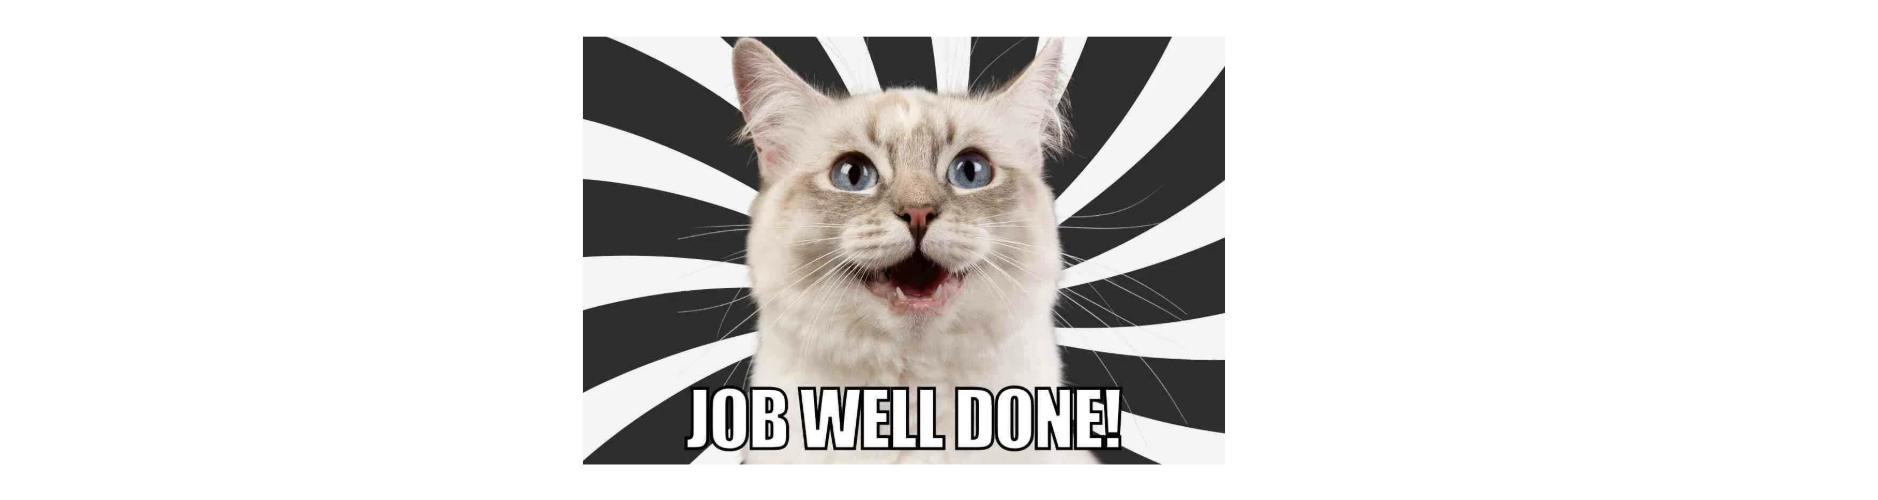